In [1]:
%env PATH=/usr/local/cuda-11.5/bin:/usr/bin:$PATH
%load_ext autoreload
%autoreload 2
%matplotlib widget

env: PATH=/usr/local/cuda-11.5/bin:/usr/bin:$PATH


In [2]:
from pinns.prelude import *
from pinns.domain import Hypercube
from pinns.calc import laplace
from scipy.stats.qmc import Sobol
from pinns.model import mlp
from pinns.opt import train_nn

import itertools
import numpy as np
import matplotlib.pyplot as plt
from jax.config import config
#config.update("jax_enable_x64", True)

In [3]:

def make_stop_condition(cond, histsize=100):
    def stop(epoch, hist):
        def _cond():
            start = epoch - histsize + 1
            slice_hist = lambda h: lax.dynamic_slice_in_dim(h, start, histsize, 0)
            _hist = tree_map(slice_hist, hist)
            return cond(_hist)
        return lax.cond(
            epoch < histsize - 1,
            lambda: False,
            _cond
        )
    return stop


In [4]:
a = 1.
b = 1.
c = jnp.linspace(0.05, 1.1, 2**9)#[:, None]
x_dom = array(Sobol(3, seed=0).random_base2(12))
x_bnd = array(Sobol(2, seed=1).random_base2(10))

x_bnd_int = array(Sobol(2, seed=1).random_base2(14))


In [5]:
def make_batches(data, batches):
    def _batches(rng):
        k1, k2 = random.split(rng)
        batch_size_dom = data.shape[0] // batches

        perms = jax.random.permutation(k1, data.shape[0])
        perms = perms[:batches * batch_size_dom]  # skip incomplete batch
        perms = perms.reshape((batches, batch_size_dom))

        _c = random.permutation(k2, c, independent=True)
        perms_c = perms % len(_c)
        
        return data[perms], _c[perms_c]
    return _batches


In [6]:
from pinns.calc import divergence
def normalize(x):
    return x / norm(x, axis=-1, keepdims=True)

m = lambda x: array([0., 0., 1.])

def l(x, c):
    x, y, z = x
    return -(x - a / 2) * (x + a / 2) * (y - b / 2) * (y + b / 2) * (z - c / 2) * (z + c / 2)

n = lambda x, c: normalize(-grad(l)(x, c))
# def n(x, c):
#     x, y, z = x
#     x1 = jnp.where(x == -a/2, -1., 0.)
#     x2 = jnp.where(x == a/2, 1., 0.)
#     nx = x1 + x2
#     y1 = jnp.where(y == -b/2, -1., 0.)
#     y2 = jnp.where(y == b/2, 1., 0.)
#     ny = y1 + y2
#     z1 = jnp.where(z == -c/2, -1., 0.)
#     z2 = jnp.where(z == c/2, 1., 0.)
#     nz = z1 + z2
#     return array([nx, ny, nz])

key, init_key = random.split(random.PRNGKey(503))
model, params = mlp(init_key, (4, 100, 100, 100, 100, 100, 100, 1), tanh)

phi1 = lambda x, c, p: l(x, c) * model.apply(p, concatenate([x, c[None]]))
#phi1 = lambda x, c, p: l(x, c) * model.apply(p, x)

tx = optax.adam(0.0005)
init_state = TrainState.create(
    apply_fn=model.apply, 
    params=params,
    tx=tx
)

def transform_dom(x, c):
    domain = Hypercube((-a / 2, -b / 2, -c / 2), (a / 2, b / 2, c / 2))
    return domain.transform(x)

def loss_phi1(params, x_dom, c):
    x_dom = vmap(transform_dom)(x_dom, c)
    _pde_loss = lambda x, c, p: (-laplace(phi1)(x, c, p) + divergence(m)(x)) ** 2
    pde_loss = mean(vmap(_pde_loss, (0, 0, None))(x_dom, c, params))
    return pde_loss, {'pde_loss': pde_loss}

In [7]:
key, train_key = random.split(key)
state_phi1, metrics_phi1 = train_nn(
    loss_phi1, init_state, make_batches(x_dom, 2**6), train_key, epochs=500)

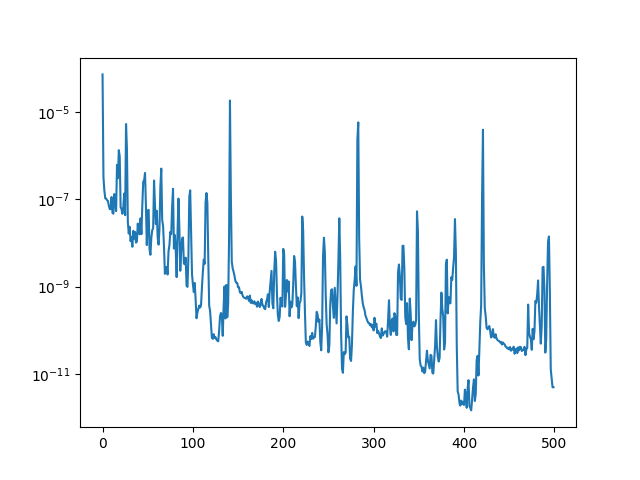

In [8]:
ax = plt.figure().subplots(1,1)
ax.plot(metrics_phi1['pde_loss'])
ax.set_yscale('log')

In [9]:
def phi2_solution(x, c, x_bnd):
    eps = 1e-7
    _phi1 = lambda x, c: phi1(x, c, state_phi1.params)
    def g(y):
        return dot(m(y), n(y, c))# - dot(grad(_phi1)(y, c), n(y, c))
    
    dist = norm(x - x_bnd, axis=-1)
    _g = vmap(g)(x_bnd)

    idx = (dist > eps) & (~jnp.isnan(_g))
    newton_kernel = where(idx, 1 / dist, 0.)
    _g = where(idx, _g, 0.)
    N = jnp.count_nonzero(idx)
    A = (2 * a * b + 2 * b * c + 2 * a * c)
    return  A / (4 * pi * N) * dot(newton_kernel, _g)

In [10]:
phi2_bnd = lambda x, c, p: model.apply(p, concatenate([x, c[None]]))
def transform_bnd(x, c):
    domain = Hypercube((-a / 2, -b / 2, -c / 2), (a / 2, b / 2, c / 2))
    return domain.transform_bnd(x)

def loss_phi2_bnd(params, x, c):
    def loss(x, c):
        x = transform_bnd(x, c)
        y = phi2_solution(x, c, transform_bnd(x_bnd_int, c))
        y_pred = phi2_bnd(x, c, params)
        return (y_pred - y) ** 2
    l = mean(vmap(loss)(x, c))
    return l, {'bnd_loss': l}


In [11]:

key, train_key = random.split(key)
state_phi2_bnd, metrics_phi2_bnd = train_nn(
    loss_phi2_bnd, init_state, make_batches(x_bnd, 2**5), train_key, epochs=10000)

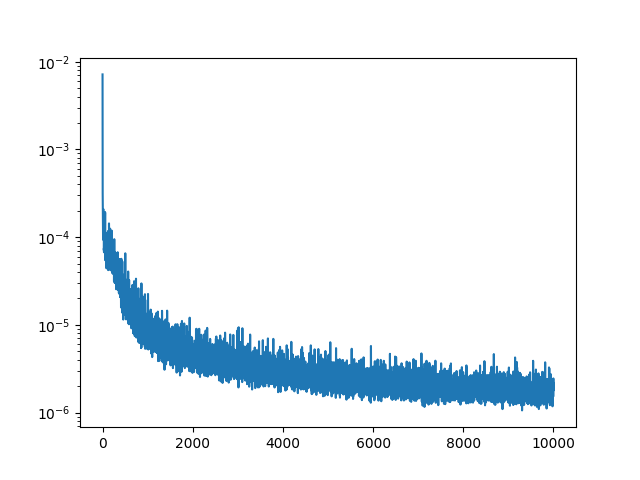

In [12]:
ax = plt.figure().subplots(1,1)
ax.plot(metrics_phi2_bnd['bnd_loss'])
ax.set_yscale('log')

In [13]:
phi2 = lambda x, c, p: (
    phi2_bnd(x, c, state_phi2_bnd.params) 
    + l(x, c) * model.apply(p, concatenate([x, c[None]]))
)
# phi2 = lambda x, c, p: (
#     phi2_bnd(x, c, state_phi2_bnd.params) 
#     + l(x, c) * model.apply(p, x)
# )


def loss_phi2(params, x_dom, c):
    def transform(x, c):
        domain = Hypercube((-a / 2, -b / 2, -c / 2), (a / 2, b / 2, c / 2))
        return domain.transform(x)
    x_dom = vmap(transform)(x_dom, c)
    _pde_loss = lambda x, c, p: (-laplace(phi2)(x, c, p)) ** 2
    pde_loss = mean(vmap(_pde_loss, (0, 0, None))(x_dom, c, params))
    return pde_loss, {'pde_loss': pde_loss}


key, train_key = random.split(key)
state_phi2, metrics_phi2 = train_nn(
    loss_phi2, init_state, make_batches(x_dom, 2**8), train_key, epochs=10000)

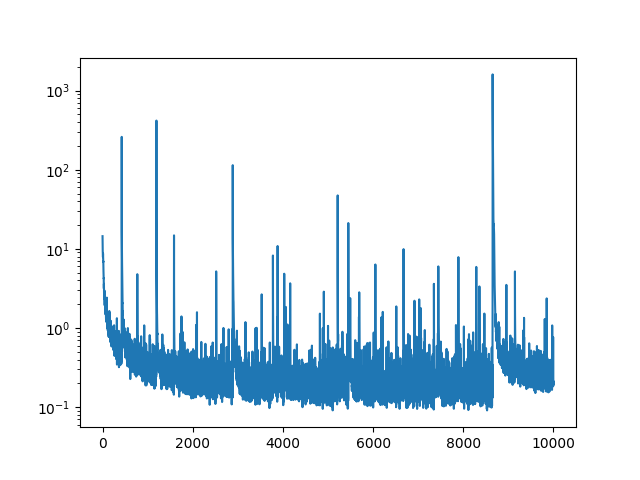

In [24]:
ax = plt.figure().subplots(1,1)
ax.plot(metrics_phi2['pde_loss'])
ax.set_yscale('log')

In [25]:
phi_nn = lambda x, c: phi1(x, c, state_phi1.params) + phi2(x, c, state_phi2.params)

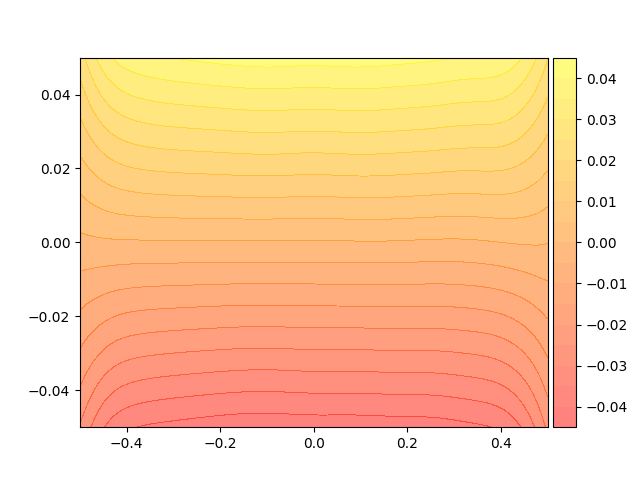

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_result(sol, c, ax):
    plt.sca(ax)
    N = 100
    x = np.linspace(-a/2, a/2, N)
    z = np.linspace(-c/2, c/2, N)

    X = np.array([_x for _x in itertools.product(x, z)])
    _X = jnp.asarray(X)
    _X = jnp.insert(_X, array([1]), zeros((N * N, 1)), 1)
    phi = np.array(sol(_X, c))

    p = ax.contourf(x, z, phi.reshape(N, N).T, 20, cmap=plt.get_cmap("autumn"), alpha=0.5)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)


# def plot_model(model, ax=None):
#     if ax is None:
#         fig = plt.figure()
#         ax = fig.add_subplot(111)
#         fig.subplots_adjust(wspace=0.4)
#     plot_result(model, ax)

_c = array(0.1)
fig = plt.figure()
ax = fig.add_subplot(111)
plot_result(vmap(phi_nn, (0, None)), _c, ax)

In [27]:
def ed(model, x, c):
    c = array(c)
    Ms = 1.
    mag = vmap(m)(x)
    H = lambda x: -grad(model)(x, c)
    e = lambda x: dot(m(x), H(x)) 
    return -Ms * (a * b * c) / 2 * jnp.sum(vmap(e)(x)) / len(x)


_x = transform_dom(x_dom, _c)
ed(phi_nn, _x, _c)

DeviceArray(0.03736513, dtype=float32)

In [18]:
1/6

0.16666666666666666

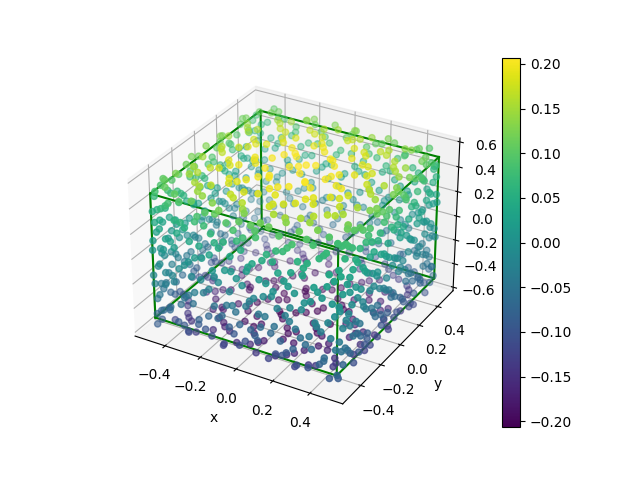

In [19]:
from itertools import combinations, product

ax = plt.figure().add_subplot(projection='3d')

r = [-0.5, 0.5]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
   if np.sum(np.abs(s-e)) == r[1]-r[0]:
      ax.plot3D(*zip(s, e), color="green")

def transform_bnd(x, c):
    domain = Hypercube((-a / 2, -b / 2, -c / 2), (a / 2, b / 2, c / 2))
    return domain.transform_bnd(x)

_c = array(1.1)
# _x_bnd = transform_bnd(x_bnd, 0.1)
_x_bnd = vmap(transform_bnd, (0, None))(x_bnd, _c)
#p = ax.scatter(_x_bnd[:, 0], _x_bnd[:, 1], _x_bnd[:, 2], c=vmap(phi2_bnd, (0, None, None))(_x_bnd, _c, state_phi2_bnd.params))

#p = ax.scatter(_x_bnd[:, 0], _x_bnd[:, 1], _x_bnd[:, 2], c=vmap(phi1, (0, None, None))(_x_bnd, c, state_phi1.params))
_x = vmap(transform_bnd, (0, None))(x_bnd_int, _c)
col = vmap(phi2_solution, (0, None, None))(_x_bnd, _c, _x)
p = ax.scatter(_x_bnd[:, 0], _x_bnd[:, 1], _x_bnd[:, 2], c=col)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.colorbar(p)

In [20]:
print(_x_bnd.shape)
#abc = jnp.abs(jnp.sum(vmap(phi2_solution, (0, None))(_x_bnd, _c), axis=-1))
any(jnp.isnan(col))

(1024, 3)


False

In [21]:
jnp.max(
    vmap(phi2_solution, (0, None, None))(_x_bnd, c[0], _x_bnd)
)


DeviceArray(0.05942069, dtype=float32)

In [22]:
_x_bnd[0]

DeviceArray([-0.5       ,  0.40452552,  0.09762204], dtype=float32)

In [23]:
#_x_bnd = vmap(transform_bnd, (0, None))(x_bnd, _c)
a1 = vmap(phi2_bnd, (0, None, None))(_x_bnd, _c, state_phi2_bnd.params)
a2 = vmap(phi2_solution, (0, None, None))(_x_bnd, _c, vmap(transform_bnd, (0, None))(x_bnd_int, _c))
jnp.max(abs(a1 - a2))

DeviceArray(0.00814201, dtype=float32)